- $k$ -- число активных соседей.
Для неактивной клетки:
- Вероятность стать активной $p_{a} = 1 - (1-d_e)(1-d_h)^k$, но при использовании параметров из статьи, (почти) все клетки активируются. Так что попробовал игнорировать количество активных соседних клеток, $p_{tba} = 1 - (1-d_e)(1-d_h)^{sign(k)}$, но численно по-прежнему не похоже на результаты из статьи.

Для активной клетки:
- Вероятность остаться активной $p_{d} = max(1 - d_e,[k=4])$. 1 если все соседние активны.

In [7]:
# %load simulation.py
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.ndimage import convolve


class Model:
    def __init__(self,
                 n=512,
                 m=128,
                 # probability that an active trader can turn one of his inactive neighbors into an active one
                 p_h=0.0485,
                 # probability to diffuse and become inactive when having at least one inactive neighbour
                 p_d=0.05,
                 # probability to spontaneously enter market dynamics
                 p_e=0.0001,
                 #
                 initial_active_freq=0.1
                 ):
        self.p_h = p_h
        self.p_e = p_e
        self.p_d = p_d
        self.n = n
        self.m = m

        self.ones = np.ones((self.n, self.m), dtype=np.byte)
        self.fours = 4 * self.ones

        self.activeness_mask = np.random.random(self.n * self.m).reshape(
            (self.n, self.m)) < (self.ones * initial_active_freq)

        self.matrix = ma.masked_array(np.zeros((n, m), dtype=np.byte), mask=self.activeness_mask,
                                      fill_value=1)

        self.not_h_matrix = self.ones * (1 - p_h)
        self.e_matrix = self.ones * p_e
        self.d_matrix = self.ones * p_d
        self.convolution_kernel = np.array([[0, 1, 0],
                                            [1, 0, 1],
                                            [0, 1, 0]], dtype=np.byte)

    def step(self):
        new_activeness_mask = np.zeros((self.n, self.m), dtype=np.bool)

        for i in range(self.n):
            for j in range(self.m):
                inactive_neighbours = []
                if j > 0 and not (self.activeness_mask[i][j - 1]):
                    inactive_neighbours.append((i, j - 1))
                if (j < self.m - 1) and not (self.activeness_mask[i][j + 1]):
                    inactive_neighbours.append((i, j + 1))
                if i > 0 and not (self.activeness_mask[i - 1][j]):
                    inactive_neighbours.append((i - 1, j))
                if (i < self.n - 1) and not (self.activeness_mask[i + 1][j]):
                    inactive_neighbours.append((i + 1, j))

                n_inactive_neighbours = len(inactive_neighbours)

                current = self.activeness_mask[i][j]

                if current == True:
                    # may become inactive
                    if (n_inactive_neighbours != 0) and (np.random.random(1) < self.p_d):
                        new_activeness_mask[i, j] = False
                    else:
                        # stay active
                        new_activeness_mask[i, j] = True
                    # may activate neighbour
                    if (n_inactive_neighbours != 0) and (np.random.random(1) < self.p_h):
                        random = np.random.random(1)
                        for k in range(n_inactive_neighbours):
                            if random < (1.0 * (k + 1) / n_inactive_neighbours):
                                (i1, j1) = inactive_neighbours[k]
                                new_activeness_mask[i1, j1] = True
                                break
                else:
                    if np.random.random(1) < self.p_e:
                        new_activeness_mask[i, j] = True
        self.activeness_mask = new_activeness_mask
        self.matrix.mask = self.activeness_mask

    def get_active_count(self):
        return np.count_nonzero(self.activeness_mask)


def animate(model: Model, t: int = 100, steps_per_frame: int = 1):
    figure = plt.figure()
    ca_plot = plt.imshow(model.matrix, cmap='seismic')

    def animation_func(i):
        for i in range(steps_per_frame):
            model.step()
        ca_plot.set_data(model.matrix.filled())
        return ca_plot

    plt.colorbar(ca_plot)
    return FuncAnimation(figure, animation_func, frames=int(t / steps_per_frame))


def simulate_and_plot(p_hs: list, initial_acitv_freqs: list, max_t):
    ts = range(1, max_t)
    active_count_series_list = []
    assert len(p_hs) == len(initial_acitv_freqs)
    for i in range(len(p_hs)):
        active_count_series_list.append(simulate(ts, Model(p_h=p_hs[i],
                                                           initial_active_freq=initial_acitv_freqs[i])))

    for index, active_count_series in enumerate(active_count_series_list):
        plt.plot(ts, active_count_series, label=p_hs[index])
    plt.legend(loc='best')


def simulate(ts, model: Model):
    active_counts = []
    for t in ts:
        model.step()
        active_count = model.get_active_count()
        active_counts.append(active_count)
    return active_counts


In [8]:
animation = animate(Model(30,30))
plt.close()
HTML(animation.to_jshtml())

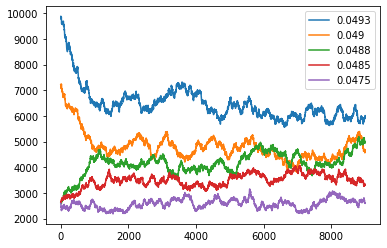

In [11]:
simulate_and_plot([0.0493, 0.0490, 0.0488, 0.0485, 0.0475,],[0.15,0.11,0.04,0.04,0.04], 9000)